## MSMs, OOMs and OPS

This explains how to run OPS simulations for dynamics defined by a Markov state model (MSM).

In [81]:
import openpathsampling as paths
import numpy as np
import openpathsampling.engines.msm as msm
import matplotlib.pyplot as plt
%matplotlib inline

Create a simple MSM, just 4 states. We should put something bigger in here.

In [82]:
mat = np.array([
    [0.95, 0.05, 0.00, 0.00],
    [0.05, 0.94, 0.01, 0.00],
    [0.00, 0.01, 0.94, 0.05],
    [0.00, 0.00, 0.05, 0.95]
])

Create an engine first. The MSM engine takes a transition matrix. No checks are done so far.

In [83]:
engine = msm.Engine(mat)

create a first snapshot. in MSM these can also be called a `MicroState`

In [84]:
snap = msm.MicroState(
    state=0,
    engine=engine
)
engine.current_snapshot = snap

Generate a first trajectory

In [85]:
%%time
traj = engine.generate_n_frames(1000)

CPU times: user 39.6 ms, sys: 1.61 ms, total: 41.3 ms
Wall time: 40.2 ms


Define macro states, here just out of single microstates

In [86]:
stateA = msm.Block([0])
stateB = msm.Block([3])

And some interfaces (not needed for TPS)

In [87]:
intA = msm.Block([0,1])
intB = msm.Block([2,3])

Define ensembles for A->B and B->A pathways

In [88]:
ensA2B = paths.SequentialEnsemble([
        paths.SingleFrameEnsemble(paths.AllInXEnsemble(stateA)),
        paths.AllOutXEnsemble(stateA | stateB),
        paths.SingleFrameEnsemble(paths.AllInXEnsemble(stateB)),        
    ])
ensB2A = paths.SequentialEnsemble([
        paths.SingleFrameEnsemble(paths.AllInXEnsemble(stateB)),
        paths.AllOutXEnsemble(stateA | stateB),
        paths.SingleFrameEnsemble(paths.AllInXEnsemble(stateA)),        
    ])

Compute the probability to reach B by starting in A and measure fraction we reach B

In [ ]:
r = []

for x in range(20000):
    tt = engine.generate(snap, ensA2AB.can_append)
    r.append(stateB(tt[-1]))
    
print 1.0 * sum(r) / len(r)

And pick the first AB path

In [89]:
# first_AB_list = ensA2B.split(traj)
# firstAB = first_AB_list[0].state

as well as the first BA path

In [90]:
# first_BA_list = ensB2A.split(traj)
# firstBA = first_AB_list[0].state

Now setting up a TPS network consisting of a transition from A2B 

In [91]:
network = paths.TPSNetwork(stateA, stateB)

and a scheme

In [92]:
scheme = paths.OneWayShootingMoveScheme(
    network, 
    selector=paths.UniformSelector(), 
    engine=engine
)

generate the initial conditions, e.g. the sampleset that is used in the beginning. For TPS this is just a single sample that is in the A2B path ensemble.

In [93]:
initial_conditions = scheme.initial_conditions_from_trajectories(traj)
print scheme.initial_conditions_report(initial_conditions)

No missing ensembles.
No extra ensembles.
No missing ensembles.
No extra ensembles.



We could save for later, but we will do this in memory.

In [94]:
# storage = paths.Storage("msm.nc", "w", use_uuid=False)
# storage.set_caching_mode('analysis')

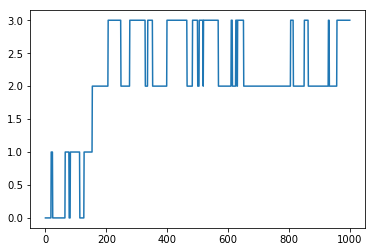

In [95]:
plt.plot(traj.state)

We use a special MSM step sampler that will add all the steps to a list instead of saving these to disk.
You could later save these using `map(storage.steps, steps)`, but we don't want to do that here.

In [96]:
steps=[]

In [97]:
sampler = msm.StepSampling(
    steplist=steps,  
    move_scheme=scheme,
    sample_set=initial_conditions
)

In [98]:
%%time
sampler.run(1000)

Working on Monte Carlo cycle number 1000
Running for 17 seconds -  0.02 seconds per step
Estimated time remaining: 0 seconds
DONE! Completed 1000 Monte Carlo cycles.
CPU times: user 16.3 s, sys: 4.87 s, total: 21.2 s
Wall time: 18 s


In [99]:
len(steps)

1001

In [100]:
# sum(map(len, storage.trajectories))

In [101]:
# len(storage.trajectories)

In case we want to analyze from storage

In [102]:
# steps = storage.steps

Get the path lengths

In [103]:
path_lengths = [len(step.active[0].trajectory) for step in steps[1:]]

Maximum: 111 (1110)
Average: 34.12 (341.23)


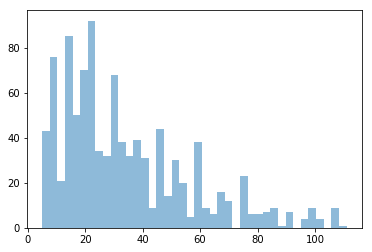

In [104]:
print "Maximum:", max(path_lengths), "("+str(max(path_lengths)*engine.snapshot_timestep)+")"
print "Average:", "{0:.2f}".format(np.mean(path_lengths)), "("+"{0:.2f}".format(np.mean(path_lengths)*engine.snapshot_timestep)+")"
plt.hist(path_lengths, bins=40, alpha=0.5);


In [105]:
ooms = np.array([np.dot(np.diag([1 if x == row else 0 for x in range(4)]), mat) for row in range(len(mat))])

Use OOM formalism to compute path probability

In [106]:
oA = ooms[0]
oNotAB = ooms[1] + ooms[2]
oB = ooms[3]
ones = np.ones(4)
pin = np.linalg.eig(mat)[1][0]
pi = pin / sum(pin)

In [107]:
v1 = np.dot(np.dot(pi, np.dot(np.dot(oA, np.dot(oNotAB, np.linalg.inv(np.eye(4) - oNotAB))), oB)), ones)
v2 = np.dot(np.dot(pi, oA), ones)

In [108]:
print 'probability of finding a path that starts in A and end in B before returning (unnormalized):', v1

probability of finding a path that starts in A and end in B before returning (unnormalized): 0.00160496919593


In [109]:
print 'probability to start in A under starting conditions (normalization):', v2

probability to start in A under starting conditions (normalization): 0.22469568743


In [110]:
print 'prob of going from A directly to B without returning (normalized)', v1 / v2

prob of going from A directly to B without returning (normalized) 0.00714285714286


An analytic expression for pathlength

In [111]:
l1 = np.dot(
    np.dot(
    pi, np.dot(
    np.dot(oA, 
           np.dot(
               (2.0 * oNotAB), 
               np.linalg.matrix_power(
                   np.linalg.inv(np.eye(4) - oNotAB), 
                   2
               )
           )
          ), 
        oB)
    ), 
ones)

In [112]:
l1 / v1

68.571428571428498

Plot the PathLength Distribution

In [113]:
def pathlength(n):
    return np.dot(np.dot(pi, np.dot(np.dot(oA, np.linalg.matrix_power(oNotAB, n)), oB)), ones) / v1

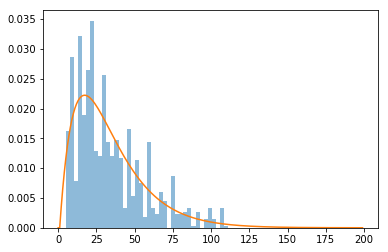

In [114]:
plt.hist(path_lengths, bins=40, alpha=0.5, normed=1);
plt.plot(map(pathlength,range(200)))
plt.show()


And some visualization

In [115]:
import openpathsampling.visualize as ops_vis
from IPython.display import SVG

In [116]:
history = ops_vis.PathTree(
    steps[:250],
    ops_vis.ReplicaEvolution(
        replica=0,
        accepted=True
    )
)
history.states = {
    'red': stateA,
    'orange': msm.Block([1]),
    'greenyellow': msm.Block([2]),
    'green': stateB
}
history.options.css['scale_x'] = 3
history.options.css['scale_y'] = 5
history.options.movers['ForwardShootMover']['suffix'] = ''
history.options.movers['BackwardShootMover']['suffix'] = ''
history.options.ui['legends'] = []
history.options.css['width'] = '100%'

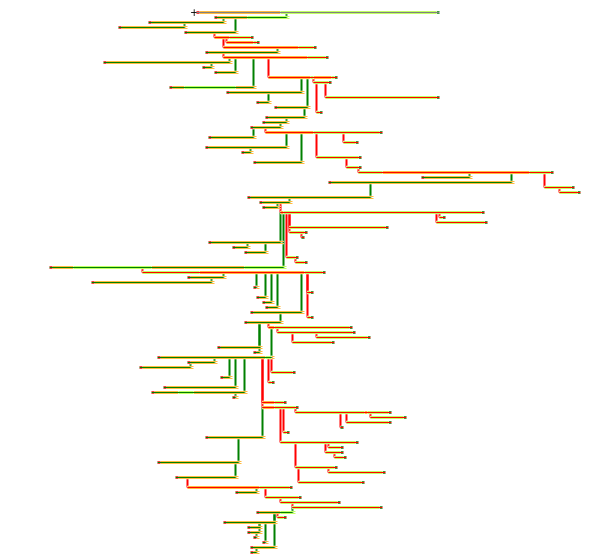

In [117]:
SVG(history.svg())

Use our example 4-well potential

In [ ]:
p = lambda x: 4.0 * (x ** 8 + 0.5 * np.exp (-40.0 * ((x + 0.5) ** 2)) +
   0.8 * np.exp (-80.0 * (x ** 2)) +
   0.2 * np.exp (-80.0 * ((x - 0.5) ** 2)))

In [ ]:
ex = np.array(map(p, np.arange(-0.99, 1.00, 0.02)))

In [ ]:
plt.plot(ex)

In [ ]:
mat2 = np.zeros( (100, 100))
beta = 1.0
for y in range(100):
    for dx in range(-1,2):
        if y + dx >=0 and y + dx < 100:
            mat2[y, y + dx] = np.exp(- beta * (np.max(ex[y + dx] - ex[y], 0) + 0 * dx*dx) )
            
    mat2[y] *= 1.0 / np.sum(mat2[y])    

In [ ]:
mat3 = np.linalg.matrix_power(mat2, 250)

In [ ]:
plt.rcParams["figure.figsize"] = 8,8
plt.matshow(mat3);

In [ ]:
engine = msm.Engine(mat3)

In [ ]:
snap = msm.MicroState(
    state=14,
    engine=engine
)
engine.current_snapshot = snap

In [ ]:
%%time
traj = engine.generate_n_frames(1000)

In [ ]:
# row and column sharing
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row')
ax1.plot(x, y)
ax1.set_title('Sharing x per column, y per row')
ax2.scatter(x, y)
ax3.scatter(x, 2 * y ** 2 - 1, color='r')
ax4.plot(x, 2 * y ** 2 - 1, color='r')

In [ ]:
plt.rcParams["figure.figsize"] = 20,6
# row and column sharing
plt.plot(traj.state)
plt.plot(ex * 50, range(0,100))

In [ ]:
stateA = msm.Block(range(00,15))
stateB = msm.Block(range(35,40))
stateC = msm.Block(range(60,65))
stateD = msm.Block(range(85,100))

In [ ]:
intA = msm.Block(range(15,20))
intB = msm.Block(range(30,45))
intC = msm.Block(range(55,70))
intD = msm.Block(range(80,85))

In [ ]:
network = paths.TPSNetwork(stateA, stateD)

In [ ]:
ensA2B = paths.SequentialEnsemble([
        paths.SingleFrameEnsemble(paths.AllInXEnsemble(stateA)),
        paths.AllOutXEnsemble(stateA | stateB),
        paths.SingleFrameEnsemble(paths.AllInXEnsemble(stateB)),        
    ])
ensB2A = paths.SequentialEnsemble([
        paths.SingleFrameEnsemble(paths.AllInXEnsemble(stateB)),
        paths.AllOutXEnsemble(stateA | stateB),
        paths.SingleFrameEnsemble(paths.AllInXEnsemble(stateA)),        
    ])

In [ ]:
scheme = paths.OneWayShootingMoveScheme(
    network, 
    selector=paths.UniformSelector(), 
    engine=engine
)

In [ ]:
initial_conditions = scheme.initial_conditions_from_trajectories(traj)
print scheme.initial_conditions_report(initial_conditions)

In [ ]:
steps100=[]

In [ ]:
sampler = msm.StepSampling(
    steplist=steps100,  
    move_scheme=scheme,
    sample_set=initial_conditions
)

In [ ]:
%%time
sampler.run(2000)

In [ ]:
history100 = ops_vis.PathTree(
    steps100[1:250],
    ops_vis.ReplicaEvolution(
        replica=0,
        accepted=True
    )
)
history100.states = {
    'red': stateA,
    'orange': stateB,
    'green': stateC,
    'blue': stateD
}
history100.options.css['scale_x'] = 3
history100.options.css['scale_y'] = 5
history100.options.movers['ForwardShootMover']['suffix'] = ''
history100.options.movers['BackwardShootMover']['suffix'] = ''
history100.options.ui['legends'] = []
history100.options.css['width'] = '100%' 
history100.options.movers['ForwardShootMover']['css_class'] = ['unknown']
history100.options.movers['BackwardShootMover']['css_class'] = ['unknown']
history100.options.movers['default']['new'] = 'line'
history100.options.movers['default']['label'] = ' '

In [ ]:
SVG(history100.svg())

In [ ]:
path_lengths = [len(step.active[0].trajectory) for step in steps100[1:]]

In [ ]:
print "Maximum:", max(path_lengths), "("+str(max(path_lengths)*engine.snapshot_timestep)+")"
print "Average:", "{0:.2f}".format(np.mean(path_lengths)), "("+"{0:.2f}".format(np.mean(path_lengths)*engine.snapshot_timestep)+")"
plt.hist(path_lengths, bins=40, alpha=0.5);

In [ ]:
ooms100 = np.array([np.dot(np.diag([1 if x == row else 0 for x in range(len(mat3))]), mat3) for row in range(len(mat3))])

In [ ]:
oA = np.sum(ooms100[list(stateA.states)], axis=0)
oB = np.sum(ooms100[list(stateB.states)], axis=0)
oC = np.sum(ooms100[list(stateC.states)], axis=0)
oD = np.sum(ooms100[list(stateD.states)], axis=0)

In [ ]:
oX = mat3 - oA - oD
ones100 = np.ones(len(mat3))
idx = 2
np.linalg.eig(mat3)[0][idx]
pin = np.linalg.eig(np.transpose(mat3))[1][:, idx]

pi = pin / sum(pin)
eye100 = np.eye(100)

In [ ]:
plt.plot(pi)

In [ ]:
v1 = np.dot(np.dot(pi, np.dot(np.dot(oA, np.dot(oX, np.linalg.inv(eye100 - oX))), oD)), ones)
v2 = np.dot(np.dot(pi, oA), ones)
v1 / v2

In [ ]:
xx = np.array([1 if x == 14 else 0 for x in range(len(mat3))])

In [ ]:
v1 = np.dot(np.dot(xx, np.dot(np.dot(oA, np.dot(oX, np.linalg.inv(eye100 - oX))), oD)), ones)
v2 = np.dot(np.dot(xx, oA), ones)
v1 / v2